Epoch 1/10
54/54 [==============================] - 290s 5s/step - loss: 0.9318 - mae: 0.0863 - val_loss: 0.2539 - val_mae: 0.1204
Epoch 2/10
54/54 [==============================] - 251s 5s/step - loss: 0.1106 - mae: 0.1694 - val_loss: 0.0609 - val_mae: 0.2238
Epoch 3/10
54/54 [==============================] - 230s 4s/step - loss: 0.1142 - mae: 0.2454 - val_loss: 0.0334 - val_mae: 0.1522
Epoch 4/10
54/54 [==============================] - 242s 4s/step - loss: 0.0985 - mae: 0.2462 - val_loss: 0.0483 - val_mae: 0.2015
Epoch 5/10
54/54 [==============================] - 238s 4s/step - loss: 0.1106 - mae: 0.2792 - val_loss: 0.0754 - val_mae: 0.2635
Epoch 6/10
54/54 [==============================] - 246s 5s/step - loss: 0.1112 - mae: 0.2811 - val_loss: 0.0963 - val_mae: 0.3008
Epoch 7/10
54/54 [==============================] - 247s 5s/step - loss: 0.1147 - mae: 0.2856 - val_loss: 0.0945 - val_mae: 0.2968
Epoch 8/10
54/54 [==============================] - 231s 4s/step - loss: 0.1118 - m

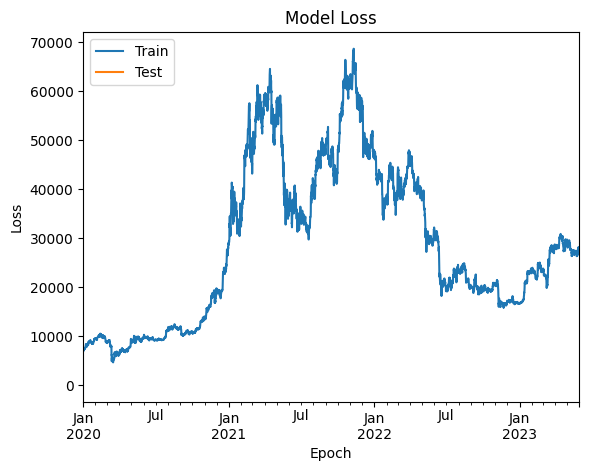

19/30 [==================>...........] - ETA: 12s

KeyboardInterrupt: 

: 

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

# Read the data from a CSV file
url = "/home/yass/code/yass2803/cryptoteller/data/BTCUSDT.csv"
df = pd.read_csv(url)
df.head()

# Change the time unit of the "open_time" column
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms', origin='unix')
df = df.drop(columns=["close_time"])

df.shape

# Plot the closing price over time
ax = df.plot(x='open_time', y='close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization
scaler = MinMaxScaler()
close_price = df.close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

scaled_close.shape

np.isnan(scaled_close).any()

# Preprocessing
class Preprocessor:
    def __init__(self, SEQ_LEN=220):
        self.SEQ_LEN=SEQ_LEN
        pass
    def to_sequences(self, data, seq_len):
        d = []

        for index in range(len(data) - seq_len):
            d.append(data[index: index + seq_len])

        return np.array(d)

    def preprocess(self, data_raw, train_split):

        data = self.to_sequences(data_raw, self.SEQ_LEN)

        self.num_train = int(train_split * data.shape[0])

        X_train = data[:self.num_train, :-1, :]
        y_train = data[:self.num_train, -1, :]

        X_test = data[self.num_train:, :-1, :]
        y_test = data[self.num_train:, -1, :]

        return X_train, y_train, X_test, y_test

preprocessor=Preprocessor()
X_train, y_train, X_test, y_test = preprocessor.preprocess(scaled_close, train_split = 0.80)

X_train.shape
X_test.shape

# Model

DROPOUT = 0.2
WINDOW_SIZE = preprocessor.SEQ_LEN - 1

model = keras.Sequential()
from tensorflow.keras.regularizers import L1L2

model.add(LSTM(WINDOW_SIZE, return_sequences=True, input_shape=(WINDOW_SIZE, X_train.shape[-1]),kernel_regularizer=L1L2(l1=0.05, l2=0.05))),

model.add(Dropout(rate=DROPOUT))

model.add(LSTM(WINDOW_SIZE * 2, return_sequences=True))
model.add(Dropout(rate=DROPOUT))

model.add(LSTM(WINDOW_SIZE, return_sequences=False))

model.add(Dense(units=1,activation='relu'))

model.add(Activation('linear'))

# Training
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

es = EarlyStopping(monitor="val_loss",
                       patience=3,
                       mode="min",
                       restore_best_weights=True)

 
model.compile(
    loss='mean_squared_error',
    metrics=["mae"] ,
    optimizer="adam"
)

BATCH_SIZE = 64

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

# Evaluation
MAE=scaler.inverse_transform([[model.evaluate(X_test, y_test)[1]]])[0][0]
print(f"MAE for the test set: {MAE}")

# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction
y_hat = model.predict(X_test)

# Inverse transform the scaled data to get the actual prices
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

# Plot the actual and predicted prices
# Prediction
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

date_time_test = df.iloc[preprocessor.num_train + preprocessor.SEQ_LEN:, 0].to_numpy()

# Plot the actual and predicted prices
plt.figure(figsize=(12, 8))  # Set the figure size to make it larger
plt.plot(date_time_test, y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test, y_hat_inverse, label="Predicted Price", color='red')

# Customize the plot
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees for better readability
plt.legend(loc='best')

plt.show()
